In [1]:
import pandas as pd
import pm4py
from pm4py.objects.log.util import dataframe_utils
from pm4py.objects.conversion.log import converter as log_converter
# from pm4py.objects.conversion.log.variants.to_event_log import Parameters
from pm4py.objects.conversion.process_tree.variants.to_petri_net import apply as pt_to_petri

from pm4py.algo.discovery.inductive.algorithm import apply as inductive_apply
# from pm4py.algo.conformance.alignments.petri_net.algorithm import apply as apply_log
from pm4py.visualization.petri_net.visualizer import view as pn_visualizer
from pm4py.visualization.petri_net.common.visualize import apply as vis_factory
from pm4py.algo.discovery.heuristics.variants.classic import apply as heuristc_miner
from pm4py.algo.conformance.alignments.petri_net.algorithm import apply as alignments_apply

import matplotlib.pyplot as plt


In [5]:
df = pd.read_pickle("../data/1_logs_org_a2.pkl")

In [6]:
status_col="concept_name" 
completed_fields=["Completed"]


cases_before = df["case_seq_num"].nunique()
df = df.sort_values(["case_seq_num", "timestamp"])
df = df.groupby("case_seq_num").filter(lambda trace: trace[status_col].iloc[-1] in completed_fields).reset_index(drop=True)
cases_after = df["case_seq_num"].nunique()
dropped = cases_before - cases_after
print(f"Dropped {dropped} cases out of {cases_before}  for not having {completed_fields} as last {status_col} in their trace ")

df = df[df[status_col].ne(df.groupby("case_seq_num")[status_col].shift())].reset_index(drop=True)
df = df[["case_seq_num", status_col, "timestamp"]]

df = df.rename(columns={
    "case_seq_num": "case:concept:name",
    status_col: "concept:name",
    "timestamp": "time:timestamp"
})
df = df.sort_values(["case:concept:name", "concept:name", "time:timestamp"])
df = dataframe_utils.convert_timestamp_columns_in_df(df)


Dropped 453 cases out of 1740  for not having ['Completed'] as last concept_name in their trace 


,count,mean,std,min,25%,50%,75%,max
duration_days,1287.0,9.683814,17.381732,0.0,0.119358,2.052465,11.600226,111.079745


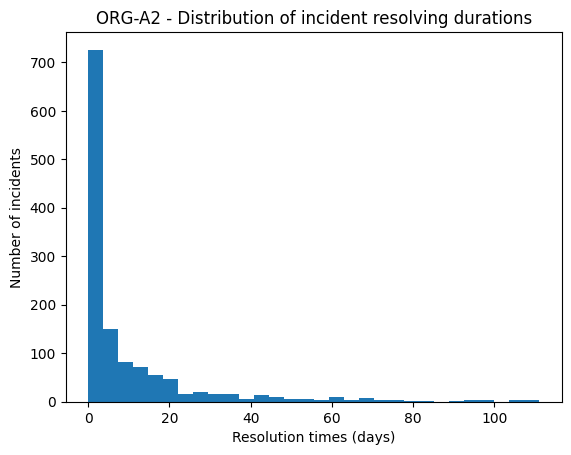

In [7]:
df = df.sort_values(["case:concept:name", "time:timestamp"])
df["time:timestamp"] = pd.to_datetime(df["time:timestamp"])
dur = df.groupby("case:concept:name")["time:timestamp"].agg(start="min", end="max").reset_index()
dur["duration"] = dur["end"] - dur["start"]
dur["duration_days"] = dur["duration"].dt.total_seconds() /  (24*60*60)
stats = dur["duration_days"].describe()
stats_df = stats.to_frame().T

plt.figure()
plt.hist(dur['duration_days'], bins=30)
plt.xlabel("Resolution times (days)")
plt.ylabel("Number of incidents")
plt.title( "ORG-A2 - Distribution of incident resolving durations")

stats_df

In [10]:
df = df.sort_values(["case:concept:name", "time:timestamp"])
trace_variants=  (
    df.groupby("case:concept:name")["concept:name"].apply(lambda seq:tuple(seq))
)
variants_counts = trace_variants.value_counts(normalize=True)
top10 = variants_counts.head(10)
print("Most common traces in ORG-A2 after filtering")
print(top10)

Most common traces in ORG-A2 after filtering
concept:name
(Queued, Accepted, Completed)                                                                                                                                            0.409479
(Accepted, Completed)                                                                                                                                                    0.215229
(Accepted, Queued, Accepted, Completed)                                                                                                                                  0.114219
(Queued, Accepted, Queued, Accepted, Completed)                                                                                                                          0.081585
(Accepted, Queued, Accepted, Queued, Accepted, Completed)                                                                                                                0.052836
(Queued, Accepted, Queued, Accepted, Queued, Accepte

In [11]:
df = pm4py.format_dataframe(
    df,
    case_id="case:concept:name",
    activity_key="concept:name",
    timestamp_key="time:timestamp",
    timest_format=None
)
lg = log_converter.apply(df, variant=log_converter.Variants.TO_EVENT_LOG)
net, im, fm = heuristc_miner(lg)

net


places: [ intplace_Accepted, pre_Accepted, pre_Completed, pre_Queued, sink0, source0 ]
transitions: [ (Accepted, 'Accepted'), (Completed, 'Completed'), (Queued, 'Queued'), (hid_2, None), (hid_4, None), (hid_6, None), (hid_7, None), (hid_8, None) ]
arcs: [ (Accepted, 'Accepted')->intplace_Accepted, (Completed, 'Completed')->sink0, (Queued, 'Queued')->pre_Accepted, (hid_2, None)->pre_Accepted, (hid_4, None)->pre_Completed, (hid_6, None)->pre_Queued, (hid_7, None)->pre_Completed, (hid_8, None)->pre_Queued, intplace_Accepted->(hid_7, None), intplace_Accepted->(hid_8, None), pre_Accepted->(Accepted, 'Accepted'), pre_Completed->(Completed, 'Completed'), pre_Queued->(Queued, 'Queued'), source0->(hid_2, None), source0->(hid_4, None), source0->(hid_6, None) ]

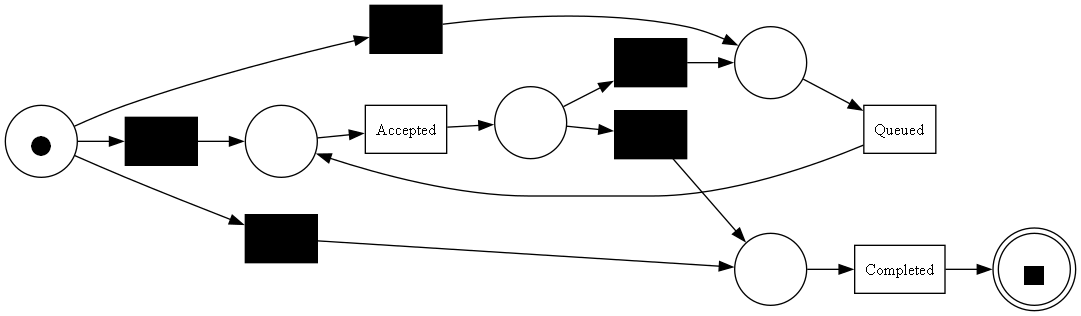

In [12]:
gviz = vis_factory(net, im, fm)
pn_visualizer(gviz)
